In [1]:
cd

/Users/keithwalcott


In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import numpy as np
from scipy.stats import linregress
import statsmodels.api as sm
from itertools import combinations
import plotly.graph_objs as go
import plotly.express as px
from ipywidgets import widgets

In [3]:
#pymol stuff
import pymol
from pymol import cmd, stored

# Initialize PyMOL in headless mode
pymol.pymol_argv = ['pymol', '-qc']
pymol.finish_launching()

# Load the structure 6xm4
cmd.fetch("6xm4", "molecule")

 ExecutiveLoad-Detail: Detected mmCIF


'molecule'

In [4]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('expand_frame_repr', False)


In [5]:
codon_variant = pd.read_csv('kw_dms/results/variants/codon_variants.csv', usecols=['barcode','library','barcode','codon_substitutions','aa_substitutions','n_codon_substitutions','n_aa_substitutions'])

def calculate_functional_score(pre_selection, pre_selection_name, post_selection, post_selection_name, library, count_threshold):
    # Rename count columns
    pre_selection.rename(columns={'count': 'count_pre'}, inplace=True)
    post_selection.rename(columns={'count': 'count_post'}, inplace=True)
    
    pre_selection = pre_selection[(pre_selection['count_pre'] >= count_threshold)] 
    
    # Merge codon_variants with 
    pre_selection = pd.merge(pre_selection, codon_variant, on='barcode')
    post_selection = pd.merge(post_selection, codon_variant, on='barcode')
    
    #filter out barcodes not in intended library
    pre_selection = pre_selection[pre_selection['library'] == library]
    post_selection = post_selection[post_selection['library'] == library]
    
    # Merge pre and post counts
    merged_df = pd.merge(pre_selection, post_selection[['barcode', 'count_post']], on='barcode', how='left')
    merged_df.fillna(0, inplace=True)
   
    # Calculate total wt counts then filter them out of the df
    wt_barcodes = merged_df[merged_df['n_codon_substitutions'] == 0]
    pre_wt_counts = wt_barcodes['count_pre'].sum()
    post_wt_counts = wt_barcodes['count_post'].sum()
    merged_df = merged_df[merged_df['n_codon_substitutions'] > 0]
    
    # Change zeroes in 'count_post' to 0.5
    # Convert 'count_post' column to float
    merged_df['count_post'] = merged_df['count_post'].astype(float)

    # Now change zeroes in 'count_post' to 0.5
    merged_df.loc[merged_df['count_post'] == 0, 'count_post'] = 0.5
    
    # Calculate the functional score for each row
    merged_df['func_score'] = np.log2((merged_df['count_post'] / post_wt_counts) / (merged_df['count_pre'] / pre_wt_counts))
 
    # Extract the specific parts of the names for renaming
    pre_suffix = pre_selection_name.split('_')[1] if '_' in pre_selection_name else 'pre'
    post_suffix = post_selection_name.split('_')[1] if '_' in post_selection_name else 'post'

    # Rename count columns
    merged_df.rename(columns={'count_pre': f'{pre_selection_name}_count'}, inplace=True)
    merged_df.rename(columns={'count_post': f'{post_selection_name}_count'}, inplace=True)

    return merged_df

In [6]:
def merge_dataframes(dataframes_dict):
    merged_group_dict = {}

    # Create combinations of the keys (and their corresponding dataframes)
    for (key1, df1), (key2, df2) in combinations(dataframes_dict.items(), 2):
        # Rename 'func_score' and 'func_score_var' columns in df1 and df2
        df1_renamed = df1.rename(columns={
            'func_score': f'{key1}_func_score',
            'func_score_var': f'{key1}_func_score_var'
        })
        df2_renamed = df2.rename(columns={
            'func_score': f'{key2}_func_score',
            'func_score_var': f'{key2}_func_score_var'
        })

        # Merge DataFrames pairwise
        merged_df = pd.merge(df1_renamed, df2_renamed, on=['barcode', 'library', 'aa_substitutions', 'n_aa_substitutions','codon_substitutions', 'n_codon_substitutions'], how='outer')

        # Drop rows with NaNs in either of the func_score columns
        func_score_cols = [col for col in merged_df.columns if '_func_score' in col]
        merged_df.dropna(subset=func_score_cols, inplace=True)

        # Process duplicate '_count' columns
        count_columns_x = [col for col in merged_df.columns if col.endswith('_x') and '_count' in col]
        count_columns_y = [col for col in merged_df.columns if col.endswith('_y') and '_count' in col]

        for col_x, col_y in zip(count_columns_x, count_columns_y):
            base_col = col_x.replace('_x', '')
            merged_df[base_col] = merged_df[col_x].fillna(merged_df[col_y])
            merged_df.drop(columns=[col_x, col_y], inplace=True)

        # Calculate the average functional score
        func_score_cols = [col for col in merged_df.columns if '_func_score' in col]
        merged_df['func_score_avg'] = merged_df[func_score_cols].mean(axis=1)

        # Sort by the average functional score
        merged_df.sort_values(by='func_score_avg', ascending=True, inplace=True)
        
        # Reset index to get a new 'rank' column
        merged_df.reset_index(drop=True, inplace=True)
        merged_df['rank'] = merged_df.index
        
        # Store the merged DataFrame
        merged_group_dict[f'{key1}-and-{key2}'] = merged_df

    return merged_group_dict


In [7]:
sample_DMSO_B1T1 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-DMSO_bio1-1_counts.csv')
sample_DMSO_B1T2 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-DMSO_bio1-2_counts.csv')
sample_DMSO_B2T1 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-DMSO_bio2-1_counts.csv')
sample_DMSO_B2T2 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-DMSO_bio2-2_counts.csv')
sample_control = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-DMSO_bio2-1_counts.csv')
sample_4u8c_B1T1 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-4u8c_bio1-1_counts.csv')
sample_4u8c_B2T1 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-4u8c_bio2-1_counts.csv')
sample_4u8c_B2T2 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-4u8c_bio2-2_counts.csv')
sample_C7_B1T2 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-C7_bio1-2_counts.csv')
sample_C7_B2T1 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-C7_bio2-1_counts.csv')
sample_Both_B1T1 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-Both_bio1-1_counts.csv')
sample_Both_B2T1 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-Both_bio2-1_counts.csv')

func_scores_KW = {}

func_scores_KW['4u8c_B1T1-vs-DMSO_B1T1']=calculate_functional_score(sample_DMSO_B1T1,'DMSO_B1T1',sample_4u8c_B1T1,'4u8c_B1T1','LibB',10)
func_scores_KW['4u8c_B2T1-vs-DMSO_B1T1']=calculate_functional_score(sample_DMSO_B1T1,'DMSO_B1T1',sample_4u8c_B2T1,'4u8c_B2T1','LibB',10)
func_scores_KW['4u8c_B2T2-vs-DMSO_B1T1']=calculate_functional_score(sample_DMSO_B1T1,'DMSO_B1T1',sample_4u8c_B2T2,'4u8c_B2T2','LibB',10)
func_scores_KW['4u8c_B2T2-vs-DMSO_B2T2']=calculate_functional_score(sample_DMSO_B2T2,'DMSO_B2T2',sample_4u8c_B2T2,'4u8c_B2T2','LibB',10)
func_scores_KW['C7_B1T2-vs-DMSO_B1T2']=calculate_functional_score(sample_DMSO_B1T2,'DMSO_B1T2',sample_C7_B1T2,'C7_B1T2','LibB',10)
func_scores_KW['C7_B2T1-vs-DMSO_B2T1']=calculate_functional_score(sample_DMSO_B2T1,'DMSO_B2T1',sample_C7_B2T1,'C7_B2T1','LibB',10)
func_scores_KW['Both_B1T1-vs-DMSO_B1T1']=calculate_functional_score(sample_DMSO_B1T1,'DMSO_B1T1',sample_Both_B1T1,'Both_B1T1','LibB',10)
func_scores_KW['Both_B2T1-vs-DMSO_B2T1']=calculate_functional_score(sample_DMSO_B2T1,'DMSO_B2T1',sample_Both_B2T1,'Both_B2T1','LibB',10)

func_score_comparisons_KW = merge_dataframes(func_scores_KW)

In [8]:
sample_1X_B1 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-Spike_DMSO_bio1_1X-1_counts.csv')
sample_5X_B1 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-Spike_DMSO_bio1_5X-1_counts.csv')
sample_10X_B1 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-Spike_DMSO_bio1_10X-1_counts.csv')
sample_1X_B2 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-Spike_DMSO_bio2_1X-1_counts.csv')
sample_5X_B2 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-Spike_DMSO_bio2_5X-1_counts.csv')
sample_10X_B2 = pd.read_csv('kw_dms/old_results/barcode_counts/LibB-231017-Spike_DMSO_bio2_10X-1_counts.csv')

func_scores_coverage = {}

func_scores_coverage['DMSO_B2T1-vs-DMSO_B1T1']=calculate_functional_score(sample_DMSO_B1T1,'DMSO_B1T1',sample_control,'dmso_B2T1_control','LibB',25)
func_scores_coverage['1X_B1-vs-DMSO_B1T1']=calculate_functional_score(sample_DMSO_B1T1,'DMSO_B1T1',sample_1X_B1,'1X_B1','LibB',25)
func_scores_coverage['5X_B1-vs-DMSO_B1T1']=calculate_functional_score(sample_DMSO_B1T1,'DMSO_B1T1',sample_5X_B1,'5X_B1','LibB',25)
func_scores_coverage['10X_B1-vs-DMSO_B1T1']=calculate_functional_score(sample_DMSO_B1T1,'DMSO_B1T1',sample_10X_B1,'10X_B1','LibB',25)
func_scores_coverage['1X_B2-vs-DMSO_B1T1']=calculate_functional_score(sample_DMSO_B1T1,'DMSO_B1T1',sample_1X_B2,'1X_B2','LibB',25)
func_scores_coverage['5X_B2-vs-DMSO_B1T1']=calculate_functional_score(sample_DMSO_B1T1,'DMSO_B1T1',sample_5X_B2,'5X_B2','LibB',25)
func_scores_coverage['10X_B2-vs-DMSO_B1T1']=calculate_functional_score(sample_DMSO_B1T1,'DMSO_B1T1',sample_10X_B2,'10X_B2','LibB',25)

func_score_comparisons_coverage = merge_dataframes(func_scores_coverage)

In [9]:
sample_noAB_B1 = pd.read_csv('SARS-CoV-2_Omicron_BA.1_spike_DMS_mAbs_kw/results/variant_counts/LibA_2022-04-13_thaw-1_no-antibody_control_1.csv', usecols=['barcode','count'])
sample_noAB_B2 = pd.read_csv('SARS-CoV-2_Omicron_BA.1_spike_DMS_mAbs_kw/results/variant_counts/LibA_2022-04-13_thaw-1_no-antibody_control_2.csv', usecols=['barcode','count'])
sample_LyCoV10_B1 = pd.read_csv('SARS-CoV-2_Omicron_BA.1_spike_DMS_mAbs_kw/results/variant_counts/LibA_2022-04-13_thaw-1_antibody_LyCoV-1404_10.464_1.csv', usecols=['barcode','count'])
sample_LyCoV10_B2 = pd.read_csv('SARS-CoV-2_Omicron_BA.1_spike_DMS_mAbs_kw/results/variant_counts/LibA_2022-04-13_thaw-1_antibody_LyCoV-1404_10.464_2.csv', usecols=['barcode','count']) 
sample_LyCoV06_B1 = pd.read_csv('SARS-CoV-2_Omicron_BA.1_spike_DMS_mAbs_kw/results/variant_counts/LibA_2022-04-13_thaw-1_antibody_LyCoV-1404_0.654_1.csv', usecols=['barcode','count'])
sample_LyCoV06_B2 = pd.read_csv('SARS-CoV-2_Omicron_BA.1_spike_DMS_mAbs_kw/results/variant_counts/LibA_2022-04-13_thaw-1_antibody_LyCoV-1404_0.654_2.csv', usecols=['barcode','count']) 
sample_LyCoV2_B1 = pd.read_csv('SARS-CoV-2_Omicron_BA.1_spike_DMS_mAbs_kw/results/variant_counts/LibA_2022-04-13_thaw-1_antibody_LyCoV-1404_2.616_1.csv', usecols=['barcode','count'])
sample_LyCoV2_B2 = pd.read_csv('SARS-CoV-2_Omicron_BA.1_spike_DMS_mAbs_kw/results/variant_counts/LibA_2022-04-13_thaw-1_antibody_LyCoV-1404_2.616_2.csv', usecols=['barcode','count']) 

func_scores_BD = {}

func_scores_BD['LyCoV10_B1-vs-noAB_B1'] = calculate_functional_score(sample_noAB_B1,'DMSO_B1',sample_LyCoV10_B1,'LyCoV10_B1','LibA',25)
func_scores_BD['LyCoV10_B2-vs-noAB_B2'] = calculate_functional_score(sample_noAB_B2,'DMSO_B2',sample_LyCoV10_B2,'LyCoV10_B2','LibA',25)
func_scores_BD['LyCoV06_B1-vs-noAB_B1'] = calculate_functional_score(sample_noAB_B1,'DMSO_B1',sample_LyCoV06_B1,'LyCoV06_B1','LibA',25)
func_scores_BD['LyCoV06_B2-vs-noAB_B2'] = calculate_functional_score(sample_noAB_B2,'DMSO_B2',sample_LyCoV06_B2,'LyCoV06_B2','LibA',25)
func_scores_BD['LyCoV2_B1-vs-noAB_B1'] = calculate_functional_score(sample_noAB_B1,'DMSO_B1',sample_LyCoV2_B1,'LyCoV2_B1','LibA',25)
func_scores_BD['LyCoV2_B2-vs-noAB_B2'] = calculate_functional_score(sample_noAB_B2,'DMSO_B2',sample_LyCoV2_B2,'LyCoV2_B2','LibA',25)

func_score_comparisons_BD = merge_dataframes(func_scores_BD)

In [10]:
def calculate_n_selections(df, threshold):
    # Filter for non-DMSO count columns
    non_dmso_count_cols = [col for col in df.columns if '_count' in col and 'DMSO' not in col]

    # Use vectorized comparison and sum across rows
    df['n_selections'] = (df[non_dmso_count_cols] >= threshold).sum(axis=1)

    return df

def calculate_n_selections_plotting(df, threshold, non_dmso_count_cols):
    df['n_selections'] = (df[non_dmso_count_cols] >= threshold).sum(axis=1)
    return df

In [11]:
def plot_func_scores(dataframes_dict, key_to_plot):
    sns.set(style='whitegrid')
    palette = {0: 'grey', 1: 'red', 2: 'blue'}

    df = dataframes_dict[key_to_plot]

    # Filter out '_func_score_var' columns and select only '_func_score' columns
    func_score_columns = [col for col in df.columns if col.endswith('_func_score') and not col.endswith('_func_score_var')]
    
    # Define a new column for point style based on n_aa_substitutions
    df['style'] = df['n_aa_substitutions'].apply(lambda x: 'variant' if x > 0 else 'WT')

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Plot for all data
    plot_scatter_and_regression(df, func_score_columns, axes[0], palette, 'All Data')

    # Exclude n_selection = 1 and plot
    df_excluded = df[df['n_selections'] != 1]
    plot_scatter_and_regression(df_excluded, func_score_columns, axes[1], palette, 'Excluding n_selection = 1')

    plt.suptitle(f'Linear Regression of Func Scores for {key_to_plot}')
    
    plt.tight_layout()
    
    plt.savefig(f'{key_to_plot}_func_scores_plot.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    
    plt.close()

def plot_scatter_and_regression(df, func_score_columns, ax, palette, title):
    df_clean = df.dropna(subset=func_score_columns)
    sns.regplot(x=func_score_columns[0], y=func_score_columns[1], data=df_clean, line_kws={'color': 'black'}, scatter=False, ax=ax)
    sns.scatterplot(x=func_score_columns[0], y=func_score_columns[1], data=df_clean, hue='n_selections', style='style', palette=palette, markers={'variant': 'X', 'WT': 'o'}, alpha=0.5, ax=ax)

    slope, intercept, r_value, p_value, std_err = linregress(df_clean[func_score_columns[0]], df_clean[func_score_columns[1]])
    ax.annotate(f'$R^2$: {r_value**2:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)

    ax.set_xlabel(func_score_columns[0])
    ax.set_ylabel(func_score_columns[1])
    ax.set_title(title)
    ax.grid(False)

    # Adjust legend
    handles, labels = ax.get_legend_handles_labels()
    n_selection_handles = handles[:len(palette)]
    n_selection_labels = labels[:len(palette)]
    style_handles = handles[len(palette):]
    style_labels = labels[len(palette):]
    ax.legend(n_selection_handles + style_handles, n_selection_labels + style_labels, title='n_selections & Style', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [12]:
def plot_r2_vs_threshold(dataframes_dict, key, threshold):
    thresholds = range(1, threshold)
    r2_values = []
    
    df = dataframes_dict.get(key)

    # Identify non-DMSO count columns and func_score columns
    non_dmso_count_cols = [col for col in df.columns if '_count' in col and 'DMSO' not in col]
    func_score_columns = [col for col in df.columns if col.endswith('_func_score') and not col.endswith('_func_score_var')]

    # Ensure there are exactly 2 func_score columns to plot
    if len(func_score_columns) == 2:
        for threshold in thresholds:
            df_threshold = calculate_n_selections_plotting(df.copy(), threshold, non_dmso_count_cols)
            df_filtered = df_threshold[df_threshold['n_selections'] != 1]

            if not df_filtered.empty:
                slope, intercept, r_value, p_value, std_err = linregress(df_filtered[func_score_columns[0]], df_filtered[func_score_columns[1]])
                r2_values.append(r_value**2)
            else:
                r2_values.append(np.nan)

        plt.figure(figsize=(10, 6))
        sns.lineplot(x=thresholds, y=r2_values)
        plt.title('R² vs. Threshold Barcode Counts')
        plt.title(f'{key}')
        plt.xlabel('Threshold Barcode Counts')
        plt.ylabel('R² Value')
        
        #plt.savefig(f'{key}_threshold_barcode_plot.png', dpi=300, bbox_inches='tight')
        
        plt.show()
    else:
        print("Expected exactly 2 func_score columns.")

# Example usage
# Assuming you have a DataFrame named 'df_example'
# plot_r2_vs_threshold(df_example)

In [13]:
def plot_count_histograms(dataframes_dict, key):
    df = dataframes_dict.get(key)
    
    sns.set(style='whitegrid')
    
    if df is not None:
        if all(n in df['n_selections'].unique() for n in [0, 1, 2]):
            dmso_count_cols = [col for col in df.columns if '_count' in col and 'DMSO' in col]

            if 1 <= len(dmso_count_cols) <= 2:
                print(f"DMSO Barcode Count Frequency For {key}")

                max_frequency, bins, colors = 0, 30, ['red', 'blue']
                fig, axes = plt.subplots(1, 3, figsize=(18, 6))

                # Calculate the total barcodes for each DMSO count column
                total_barcodes = {col: df[col].sum() for col in dmso_count_cols}

                for i, n_sel in enumerate([0, 1, 2]):
                    df_filtered = df[df['n_selections'] == n_sel]
                    legend_labels = []

                    for col, color in zip(dmso_count_cols, colors):
                        counts, bin_edges = np.histogram(df_filtered[col].dropna(), bins=bins)
                        max_frequency = max(max_frequency, max(counts))

                        sns.histplot(df_filtered[col], ax=axes[i], bins=bins, kde=False, alpha=0.5, color=color)

                        # Calculate and format the percentage for the legend
                        percentage = (df_filtered[col].sum() / total_barcodes[col]) * 100
                        legend_label = f'{col} ({percentage:.2f}%)'
                        legend_labels.append(legend_label)

                    axes[i].set_yscale('log')
                    axes[i].set_title(f'(n_selections = {n_sel})')
                    axes[i].set_xlabel('Count')
                    axes[i].set_ylabel('Number of Barcodes' if i == 0 else '')
                    axes[i].legend(labels=legend_labels)

                for ax in axes:
                    ax.set_ylim(1, max_frequency * 1.5)

                plt.tight_layout()
                #plt.savefig(f'{key}_histograms_plot.png', dpi=300, bbox_inches='tight')
                plt.show()
            else:
                print(f"Expected 1 or 2 DMSO count columns, found {len(dmso_count_cols)}")
        else:
            print(f"Skipping {key} as it does not contain all n_selections values (0, 1, 2)")
    else:
        print(f"No DataFrame found for key '{key}'")


In [14]:
def plot_barcode_count_comparison(dataframes_dict, key):
    df = dataframes_dict[key]
    
    sns.set(style='whitegrid')

    # Splitting columns into DMSO and non-DMSO
    dms_columns = [col for col in df.columns if 'DMSO' in col and col.endswith('_count')]
    non_dms_columns = [col for col in df.columns if 'DMSO' not in col and col.endswith('_count')]

    def plot_comparison(columns, title, axes, plot_index, total_plots):
        num_plots = len(columns) * (len(columns) - 1) // 2
        for i in range(len(columns)):
            for j in range(i + 1, len(columns)):
                ax = axes[plot_index] if total_plots > 1 else axes

                # Apply log transformation
                log_col_i = np.log(df[columns[i]])
                log_col_j = np.log(df[columns[j]])

                # Seaborn scatter plot with log-transformed data
                sns.scatterplot(x=log_col_i, y=log_col_j, ax=ax)

                ax.set_xlabel(f'Log of {columns[i]}')
                ax.set_ylabel(f'Log of {columns[j]}')
                ax.set_title(f'Log of {columns[i]} vs Log of {columns[j]}')

                # Linear regression
                X = sm.add_constant(log_col_i)
                Y = log_col_j
                model = sm.OLS(Y, X).fit()
                predicted_values = model.predict(X)

                # Plotting regression line
                ax.plot(log_col_i, predicted_values, color='black', linewidth=2)

                # Display R-squared on plot
                r_squared = model.rsquared
                ax.text(0.05, 0.95, f'R² = {r_squared:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')
                
                plot_index += 1

        return plot_index

    total_plots = len(dms_columns) * (len(dms_columns) - 1) // 2 + len(non_dms_columns) * (len(non_dms_columns) - 1) // 2
    fig, axes = plt.subplots(1, total_plots, figsize=(total_plots * 5, 5)) if total_plots > 1 else plt.subplots()

    plot_index = 0
    plot_index = plot_comparison(dms_columns, "DMSO Counts", axes, plot_index, total_plots)
    plot_comparison(non_dms_columns, "Non-DMSO Counts", axes, plot_index, total_plots)

    plt.tight_layout()
    plt.show()
    # Optional: Saving the figure
    filename = f'comparison_{key}.png'
    fig.savefig(filename, format='png', dpi=600)

# Example usage
# plot_barcode_count_comparison(my_dataframes_dict, 'my_key')


In [15]:
specific_key = '4u8c_B1T1-vs-DMSO_B1T1-and-4u8c_B2T2-vs-DMSO_B2T2'  # Replace this with the actual key you want to use

# Access the DataFrame using the key
specific_df = func_score_comparisons_KW[specific_key]

# Display the column names
print(specific_df.columns)

Index(['barcode', 'DMSO_B1T1_count', 'library', 'codon_substitutions', 'aa_substitutions', 'n_codon_substitutions', 'n_aa_substitutions', '4u8c_B1T1_count', '4u8c_B1T1-vs-DMSO_B1T1_func_score', 'DMSO_B2T2_count', '4u8c_B2T2_count', '4u8c_B2T2-vs-DMSO_B2T2_func_score', 'func_score_avg', 'rank'], dtype='object')


In [16]:
for key in func_score_comparisons_KW:
    func_score_comparisons_KW[key] = calculate_n_selections(func_score_comparisons_KW[key], 10)

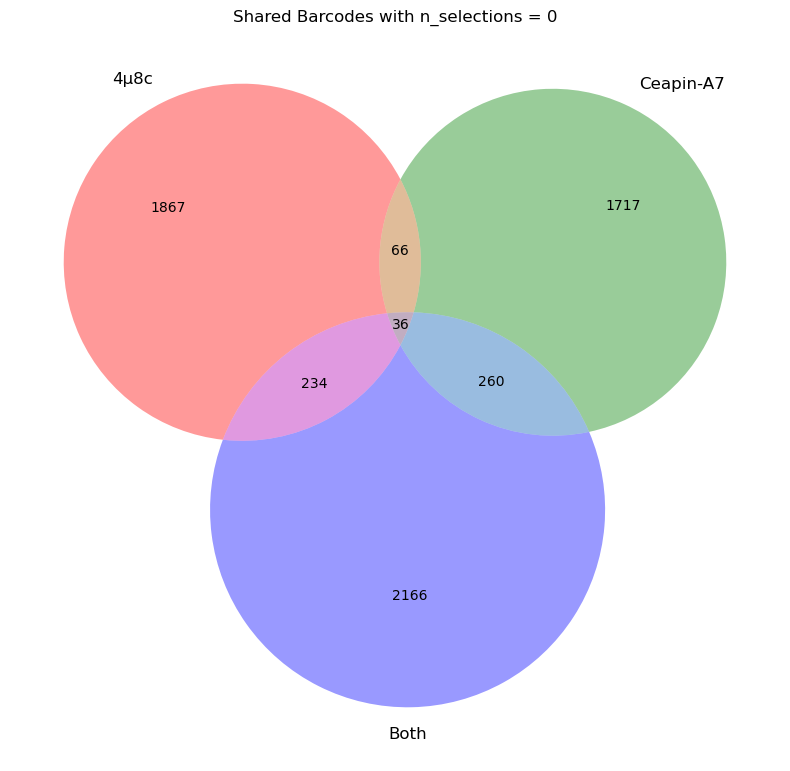

In [17]:
df_4u8c = func_score_comparisons_KW['4u8c_B1T1-vs-DMSO_B1T1-and-4u8c_B2T2-vs-DMSO_B2T2']

df_C7 = func_score_comparisons_KW['C7_B1T2-vs-DMSO_B1T2-and-C7_B2T1-vs-DMSO_B2T1']

df_Both = func_score_comparisons_KW['Both_B1T1-vs-DMSO_B1T1-and-Both_B2T1-vs-DMSO_B2T1']

df_4u8c_barcodes = df_4u8c[df_4u8c['n_selections'] == 0]['barcode']
df_C7_barcodes = df_C7[df_C7['n_selections'] == 0]['barcode']
df_Both_barcodes = df_Both[df_Both['n_selections'] == 0]['barcode']

# Create sets of barcodes
set1 = set(df_4u8c_barcodes)
set2 = set(df_C7_barcodes)
set3 = set(df_Both_barcodes)

# Generate Venn diagram
plt.figure(figsize=(8, 8))
venn3([set1, set2, set3], ('4µ8c', 'Ceapin-A7', 'Both'))
plt.title("Shared Barcodes with n_selections = 0")

plt.tight_layout()

#plt.savefig('venn_diagram.png', format='png', dpi=300)

plt.show()

In [18]:
df_4u8c_filtered = df_4u8c[df_4u8c['n_selections'] == 0][['barcode', '4u8c_B1T1-vs-DMSO_B1T1_func_score', '4u8c_B2T2-vs-DMSO_B2T2_func_score']]
df_C7_filtered = df_C7[df_C7['n_selections'] == 0][['barcode', 'C7_B1T2-vs-DMSO_B1T2_func_score', 'C7_B2T1-vs-DMSO_B2T1_func_score']]
df_Both_filtered = df_Both[df_Both['n_selections'] == 0][['barcode', 'Both_B1T1-vs-DMSO_B1T1_func_score', 'Both_B2T1-vs-DMSO_B2T1_func_score']]

# df_4u8c = df_4u8c[['barcode','DMSO_B2T2_count']]
# df_C7 = df_C7[['barcode','DMSO_B1T2_count','DMSO_B2T1_count']]
# df_Both = df_Both[['barcode','DMSO_B1T1_count']]

filtered_overlap = pd.merge(df_4u8c_filtered , df_C7_filtered, on='barcode', how='outer')
filtered_overlap = pd.merge(filtered_overlap,df_Both_filtered, on='barcode', how='outer')

In [19]:
only_in_1 = set1 - set2 - set3
only_in_2 = set2 - set1 - set3
only_in_3 = set3 - set1 - set2
in_1_and_2 = set1 & set2 - set3
in_1_and_3 = set1 & set3 - set2
in_2_and_3 = set2 & set3 - set1
in_all_three = set1 & set2 & set3

In [20]:
overlap = filtered_overlap[filtered_overlap['barcode'].isin(in_1_and_3)]

# Reshape the dataframe
reshaped_overlap = overlap.melt(id_vars=['barcode'], var_name='func_score_type', value_name='func_score').dropna(subset=['func_score'])

# Drop NaN values and calculate mean and SEM
mean_value = reshaped_overlap['func_score'].mean()
sem_value = reshaped_overlap['func_score'].sem()

# print("Mean values:\n", mean_value)
# print("\nSEM values:\n", sem_value)

<Axes: xlabel='n_codon_substitutions', ylabel='Count'>

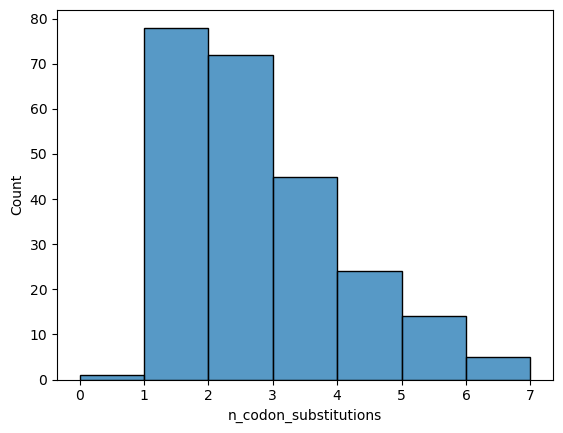

In [21]:
# Assuming 'overlap' is a subset of another DataFrame and you need a separate copy
overlap_avg = overlap.copy()

# Select columns with float data type
float_cols = overlap_avg.select_dtypes(include=['float64']).columns

# Calculate the mean of the float columns
overlap_avg['Average'] = overlap_avg[float_cols].mean(axis=1)

# Merge DataFrames on 'Key'
overlap_merged = pd.merge(overlap_avg, codon_variant, on='barcode', how='left').sort_values(by='Average', ascending=True)

sns.histplot(data=overlap_merged, x='n_codon_substitutions',  binwidth=1)

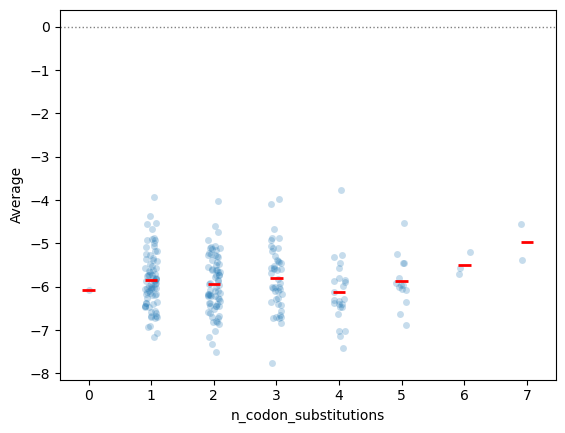

In [22]:
# Create a strip plot
sns.stripplot(x='n_codon_substitutions', y='Average', data=overlap_merged, jitter=True, alpha=0.25)

# Add a horizontal dotted line at y=0
plt.axhline(0, color='grey', linestyle='dotted', linewidth=1)

# Add mean bars for each 'n_codon_substitutions' value
n_codon_values = overlap_merged['n_codon_substitutions'].unique()
for n_codon in n_codon_values:
    mean_val = overlap_merged[overlap_merged['n_codon_substitutions'] == n_codon]['Average'].mean()
    plt.hlines(mean_val, n_codon - 0.1, n_codon + 0.1, colors='red', linewidth=2, zorder=3)

plt.show()

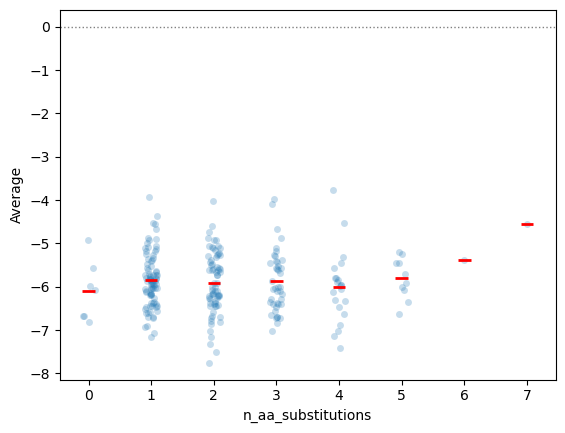

In [23]:
# Create a strip plot
sns.stripplot(x='n_aa_substitutions', y='Average', data=overlap_merged, jitter=True, alpha=0.25)

# Add a horizontal dotted line at y=0
plt.axhline(0, color='grey', linestyle='dotted', linewidth=1)

# Add mean bars for each 'n_codon_substitutions' value
n_codon_values = overlap_merged['n_aa_substitutions'].unique()
for n_codon in n_codon_values:
    mean_val = overlap_merged[overlap_merged['n_aa_substitutions'] == n_codon]['Average'].mean()
    plt.hlines(mean_val, n_codon - 0.1, n_codon + 0.1, colors='red', linewidth=2, zorder=3)

plt.show()


In [26]:
overlap_merged

,barcode,4u8c_B1T1-vs-DMSO_B1T1_func_score,4u8c_B2T2-vs-DMSO_B2T2_func_score,C7_B1T2-vs-DMSO_B1T2_func_score,C7_B2T1-vs-DMSO_B2T1_func_score,Both_B1T1-vs-DMSO_B1T1_func_score,Both_B2T1-vs-DMSO_B2T1_func_score,Average,library,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
14,TCACCACTCTCGTGAA,-8.174436,-6.567898,NaN,NaN,-7.616317,-8.660689,-7.754835,LibB,TTC152CTC TGG255TGC CTG1231CTA,F152L W255C,3,2
11,AAAGAACCACCACTGG,-7.336324,-7.473039,NaN,NaN,-6.778205,-8.400374,-7.496985,LibB,CCT80CAC CCA1087AGC,P80H P1087S,2,2
18,CTGCTGTGCTAAGCAT,-7.918597,-6.554723,NaN,NaN,-7.360478,-7.803133,-7.409233,LibB,TCT69CTG GAC212GCC GAG987AAG AGG1088ATG,S69L D212A E987K R1088M,4,4
19,TTAACTTCGGTCGACT,-7.174436,-7.212803,NaN,NaN,-6.616317,-8.272618,-7.319044,LibB,GAC140GGC TAC199CAC,D140G Y199H,2,2
17,AATAAATGGGAGGATG,-8.607395,-5.895063,NaN,NaN,-7.049277,-7.082515,-7.158563,LibB,GCT567GGC,A567G,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,TTCGGACCATGAGATC,-4.022433,-4.059557,NaN,NaN,-3.464314,-4.790749,-4.084263,LibB,ATC206GTC CAG215CTG CCA381GGG,I206V Q215L P381G,3,3
230,CCAAAAAGATACCCGA,-4.981791,-3.541426,NaN,NaN,-2.423672,-5.102693,-4.012396,LibB,CTG108GTG GAC173GGC,L108V D173G,2,2
235,TGACAGCGTACTTTAA,-3.759399,-3.371501,NaN,NaN,-4.616317,-4.142222,-3.972360,LibB,GGC73CGG GAT86TAC ACA1114AAC,G73R D86Y T1114N,3,3
238,AGTAATAGACAATCCA,-2.267545,-3.740735,NaN,NaN,-2.294389,-7.408502,-3.927793,LibB,ACC569CAC,T569H,1,1


In [42]:
# Create a list of tuples (codon_substitution, average), checking if 'codon_substitutions' is a string
data_tuples = [(sub, row['Average']) for index, row in overlap_merged.iterrows() if isinstance(row['aa_substitutions'], str) for sub in row['aa_substitutions'].split()]

# Create a new DataFrame from the list of tuples
new_df = pd.DataFrame(data_tuples, columns=['aa_substitutions', 'Average'])

# Function to extract the second letter
def extract_mutant_residue(substitution):
    if isinstance(substitution, str) and len(substitution) > 1:
        return substitution[1]
    return None

new_df['mutant residue'] = new_df['aa_substitutions'].str[-1]

new_df['site'] = new_df['aa_substitutions'].str.extract('(\d+)')

print(new_df)

    aa_substitutions   Average mutant residue  site
0              F152L -7.754835              L   152
1              W255C -7.754835              C   255
2               P80H -7.496985              H    80
3             P1087S -7.496985              S  1087
4               S69L -7.409233              L    69
..               ...       ...            ...   ...
499            T569H -3.927793              H   569
500            C134R -3.772822              R   134
501            N474V -3.772822              V   474
502            M694I -3.772822              I   694
503            E777K -3.772822              K   777

[504 rows x 4 columns]


In [32]:
sasa_data = pd.read_csv('kw_dms/sasa_data.csv')
sasa_data.rename(columns={'Residue Number': 'site'}, inplace=True)

def get_charge(amino_acid):
    if amino_acid in ['R', 'K', 'H']:
        return 'Positive'
    elif amino_acid in ['D', 'E']:
        return 'Negative'
    else:
        return 'Neutral'

def get_polarity(amino_acid):
    if amino_acid in ['R', 'K', 'H', 'D', 'E', 'S', 'T', 'N', 'Q', 'Y']:
        return 'Polar'
    else:
        return 'Nonpolar'

In [46]:
new_df['charge_status'] = new_df['mutant residue'].apply(get_charge)
new_df['polarity'] = new_df['mutant residue'].apply(get_polarity)

#formatting
new_df['site'] = new_df['site'].str.extract(r'(\d+)').astype(int)

In [43]:
# Initialize a list in the stored namespace
stored.secondary_structures = []

# Iterate over each residue and store its secondary structure in the stored list
cmd.iterate("molecule and name CA", "stored.secondary_structures.append((resi, ss))")

# Print secondary structure for each residue

#'stored.secondary_structures' contains your PyMOL data
# Convert to DataFrame
ss_df = pd.DataFrame(stored.secondary_structures, columns=['site', 'secondary_structure'])

# Function to determine secondary structure
def determine_structure(ss):
    if ss == 'H':
        return 'Alpha Helix'
    elif ss == 'S':
        return 'Beta Sheet'
    else:
        return 'Loop'

# Apply the function to each row in the 'secondary_structure' column
ss_df['secondary_structure'] = ss_df['secondary_structure'].apply(determine_structure)

# Convert 'site' to int in ss_df and remove duplicates
ss_df['site'] = ss_df['site'].astype(int)
ss_df.drop_duplicates(subset=['site'], inplace=True)

In [52]:
merged_secondary = pd.merge(new_df, ss_df, on='site')
merged_secondary = pd.merge(merged_secondary, sasa_data, on='site')

In [53]:
# Filter for 'Alpha Helix', 'Beta Sheet', and 'Loop'
alpha_helix = merged_secondary[merged_secondary['secondary_structure'] == 'Alpha Helix']
alpha_helix['Category'] = 'Alpha Helix'
beta_sheet = merged_secondary[merged_secondary['secondary_structure'] == 'Beta Sheet']
beta_sheet['Category'] = 'Beta Sheet'
loop = merged_secondary[merged_secondary['secondary_structure'] == 'Loop']
loop['Category'] = 'Loop'
all_sites = merged_secondary.copy()
all_sites['Category'] = 'All Sites'

# filter for surface accessibility
exposed = merged_secondary[merged_secondary['surface_accessibility'] == 'Exposed']
exposed['Category'] = 'Exposed'
burried = merged_secondary[merged_secondary['surface_accessibility'] == 'Burried']
burried['Category'] = 'Burried'

/var/folders/s8/ss0x2nk51635p1y7fw9sf1380000gn/T/ipykernel_10696/1890898071.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alpha_helix['Category'] = 'Alpha Helix'
/var/folders/s8/ss0x2nk51635p1y7fw9sf1380000gn/T/ipykernel_10696/1890898071.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beta_sheet['Category'] = 'Beta Sheet'
/var/folders/s8/ss0x2nk51635p1y7fw9sf1380000gn/T/ipykernel_10696/1890898071.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [55]:
data_for_plotting = pd.concat([ all_sites, alpha_helix, beta_sheet, loop, exposed, burried])
data_for_plotting = data_for_plotting[['Category', 'Average']]

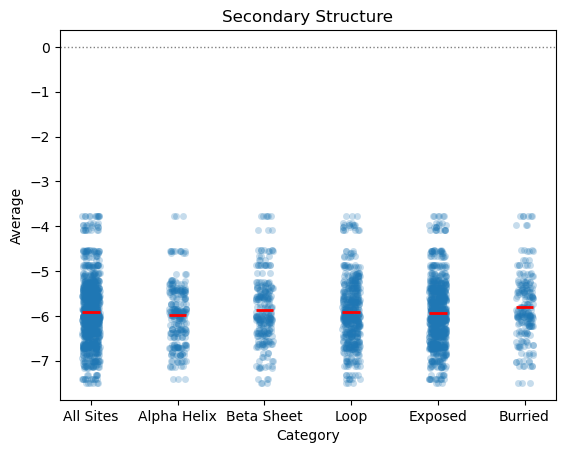

In [56]:
sns.stripplot(x='Category', y='Average', data=data_for_plotting, jitter=True, alpha=0.25)

# Add a horizontal dotted line at y=0
plt.axhline(0, color='grey', linestyle='dotted', linewidth=1)

# Add mean bars for each category
categories = data_for_plotting['Category'].unique()
for i, category in enumerate(categories):
    mean_val = data_for_plotting[data_for_plotting['Category'] == category]['Average'].mean()
    plt.hlines(mean_val, i - 0.1, i + 0.1, colors='red', linewidth=2, zorder=3)

plt.title('Secondary Structure')
plt.show()

In [ ]:
# plot func score comparison and barcode counts
plot_func_scores(func_score_comparisons_KW, specific_key)
plot_barcode_count_comparison(func_score_comparisons_KW, specific_key)

In [ ]:
#randomly sampling dataframes
func_score_comparisons_KW_sampled = {key: df.sample(n=min(len(df), 500)) for key, df in func_score_comparisons_KW.items()}

specific_key = '4u8c_B1T1-vs-DMSO_B1T1-and-4u8c_B2T2-vs-DMSO_B2T2' # Replace this with the actual key you want to use

# Access the DataFrame using the key
specific_df = func_score_comparisons_KW_sampled[specific_key]

# save current df to csv
specific_df.to_csv('sampled_4u8c_B1T1-vs-DMSO_B1T1-and-4u8c_B2T2-vs-DMSO_B2T2.csv', index=False)

# plot func score comparison and barcode counts
plot_func_scores(func_score_comparisons_KW_sampled, specific_key)
plot_barcode_count_comparison(func_score_comparisons_KW_sampled, specific_key)
plot_count_histograms(func_score_comparisons_KW_sampled, specific_key)

In [ ]:
func_scores_KW['4u8c_B2T2-vs-DMSO_B2T2']=calculate_functional_score(sample_DMSO_B2T2,'DMSO_B2T2',sample_4u8c_B2T2,'4u8c_B2T2','LibB',10)

In [ ]:
# Create lists of columns based on suffix
DMSO_count_columns = [col for col in specific_df.columns if 'DMSO' in col and col.endswith('_count')]
non_DMSO_count_columns = [col for col in specific_df.columns if 'DMSO' not in col and col.endswith('_count')]
func_columns = [col for col in specific_df.columns if col and col.endswith('_func_score')]

# Combine the lists to create a new column order
new_column_order = DMSO_count_columns + non_DMSO_count_columns + func_columns

# Reorder the DataFrame columns
specific_df = specific_df[new_column_order]

# Filter columns that end with '_count' or '_func_score'
selected_columns = [col for col in specific_df.columns if col.endswith('_count') or col.endswith('_func_score')]

# Select 20 random entries
random_entries = specific_df.sample(n=20)